### References:
* https://github.com/bwange/Item2vec_Tutorial_with_Recommender_System_Application/blob/master/Making_Your_Own_Recommender_System_with_Item2Vec.ipynb
* Python package: https://librecommender.readthedocs.io/en/latest/api/algorithms/item2vec.html
* Item2Vec + Metadata-> MetaItem2Vec: https://bytes.swiggy.com/item2vec-with-metadata-incorporating-side-information-in-item-embeddings-167fb8d3f404
* item2vec for music recomm: https://towardsdatascience.com/using-word2vec-for-music-recommendations-bb9649ac2484
* https://www.griddynamics.com/blog/customer2vec-representation-learning-and-automl-for-customer-analytics-and-personalization


In [1]:
import os
import pandas as pd
import numpy as np
os.getcwd()

'c:\\Users\\manpresingh\\OneDrive - Microsoft\\Personal\\Recommendation Models'

In [2]:
df_movies = pd.read_csv('./ml-latest-small/movies.csv')
df_ratings = pd.read_csv('./ml-latest-small/ratings.csv')

In [37]:

movieId_to_name = pd.Series(df_movies.title.values, index = df_movies.movieId.values).to_dict()
name_to_movieId = pd.Series(df_movies.movieId.values, index = df_movies.title).to_dict()

In [39]:
movieId_to_name[1]

'Toy Story (1995)'

In [6]:
df_movies.shape, df_ratings.shape

((9742, 3), (100836, 4))

In [4]:
df_movies.head(5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
df_ratings.head(5)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


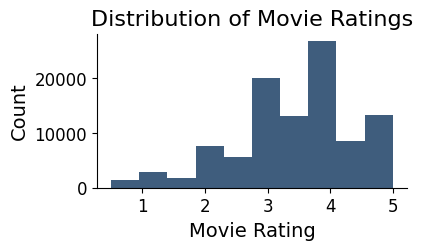

In [10]:
import matplotlib.pyplot as plt
import chart_studio.plotly as py
%matplotlib inline

plt.figure(figsize=(4, 2))
ax = plt.subplot(111)
ax.set_title("Distribution of Movie Ratings", fontsize=16)
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
  
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)  
  
plt.xlabel("Movie Rating", fontsize=14)  
plt.ylabel("Count", fontsize=14)  
  
plt.hist(df_ratings['rating'], color="#3F5D7D")  

plt.show()

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
df_ratings_train, df_ratings_test = train_test_split(df_ratings, stratify=df_ratings['userId'],
                                                     random_state=100,
                                                     test_size=.2)

In [ ]:
df_ratings

In [13]:
print("Number of training data: "+str(len(df_ratings_train)))
print("Number of test data: "+str(len(df_ratings_test)))

Number of training data: 80668
Number of test data: 20168


In [218]:
df_ratings_train

,userId,movieId,rating,timestamp,liked,movie_Id
78097,484,3911,4.0,1342294787,1,3911
33900,232,10,3.0,1218167397,0,10
94410,599,26940,2.5,1519346264,0,26940
85385,555,724,5.0,978745225,1,724
78341,487,31658,3.5,1428574498,0,31658
...,...,...,...,...,...,...
79624,495,7163,4.5,1458636189,1,7163
57080,380,1544,4.0,1493667555,1,1544
56692,377,1262,4.5,1340341828,1,1262
96597,603,2118,3.0,953925630,0,2118


In [228]:
df_ratings_train_new = pd.merge(df_ratings_train, df_movies, on='movieId', how='left').drop(columns=['movieId'])

In [230]:
df_ratings_train_new.head(5)

,userId,rating,timestamp,liked,movie_Id,title,genres
0,484,4.0,1342294787,1,3911,Best in Show (2000),Comedy
1,232,3.0,1218167397,0,10,GoldenEye (1995),Action|Adventure|Thriller
2,599,2.5,1519346264,0,26940,"Late Shift, The (1996)",Comedy
3,555,5.0,978745225,1,724,"Craft, The (1996)",Drama|Fantasy|Horror|Thriller
4,487,3.5,1428574498,0,31658,Howl's Moving Castle (Hauru no ugoku shiro) (2...,Adventure|Animation|Fantasy|Romance


In [233]:
def rating_splitter(df):
    df['liked']= np.where(df['rating']>=4,1,0)
    df['title'] = df['title'].astype('str')
    gp_user_like = df.groupby(['liked','userId'])
    
    return ([gp_user_like.get_group(gp)['title'].tolist() for gp in gp_user_like.groups])

In [234]:
pd.options.mode.chained_assignment=None

splitted_movies = rating_splitter(df_ratings_train_new)

In [238]:
splitted_movies[1]

['Dark Knight Rises, The (2012)',
 'Zombieland (2009)',
 'Girl with the Dragon Tattoo, The (2011)',
 'Exit Through the Gift Shop (2010)',
 'Ex Machina (2015)',
 'Collateral (2004)',
 'The Drop (2014)']

In [240]:
len(splitted_movies)

1215

In [241]:
len(splitted_movies[4])

16

In [242]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')

import gensim
assert gensim.models.word2vec.FAST_VERSION > -1

In [243]:
import random

for movie_list in splitted_movies:
    random.shuffle(movie_list)

In [244]:
splitted_movies

[['Encino Man (1992)',
  'Blown Away (1994)',
  'Stargate (1994)',
  'Clerks (1994)',
  'I Know What You Did Last Summer (1997)',
  'Shining, The (1980)',
  'Mrs. Doubtfire (1993)',
  'Sister Act (1992)',
  'Men in Black (a.k.a. MIB) (1997)',
  'Rocky Horror Picture Show, The (1975)',
  'Toys (1992)',
  'Mummy, The (1999)',
  'Starship Troopers (1997)',
  'Talented Mr. Ripley, The (1999)',
  "McHale's Navy (1997)",
  "Logan's Run (1976)",
  'I Still Know What You Did Last Summer (1998)',
  'Last of the Mohicans, The (1992)',
  'Twister (1996)',
  'Independence Day (a.k.a. ID4) (1996)',
  'Mission: Impossible (1996)',
  'Psycho (1998)',
  'Pulp Fiction (1994)',
  'Batman Returns (1992)',
  "Pete's Dragon (1977)",
  'Sneakers (1992)',
  'Psycho (1960)'],
 ['The Drop (2014)',
  'Ex Machina (2015)',
  'Dark Knight Rises, The (2012)',
  'Exit Through the Gift Shop (2010)',
  'Collateral (2004)',
  'Zombieland (2009)',
  'Girl with the Dragon Tattoo, The (2011)'],
 ["Schindler's List (1993)"

**IMPORTANT: Why is it riskt to take movieId instead of movieName ?**
* Because as we can see in below image, word2vec works both on index and word.
* Now, if we take movieId (which is number like index), when we ask for similar words, we are not
sure if we are asking similar words for an index or for a movieId

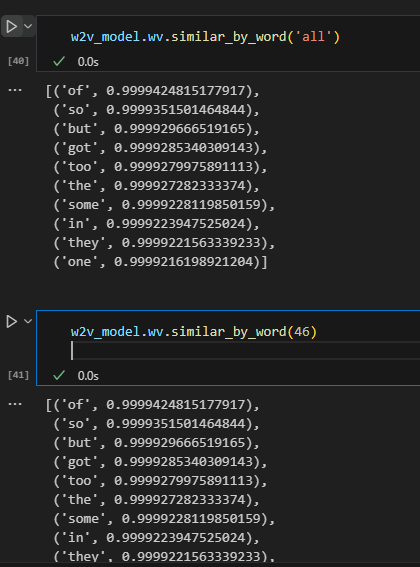

In [245]:
from gensim.models import Word2Vec
import datetime
start = datetime.datetime.now()

model = Word2Vec(sentences = splitted_movies, # We will supply the pre-processed list of moive lists to this parameter
                 epochs = 5, # epoch
                 min_count = 10, # a movie has to appear more than 10 times to be keeped
                 vector_size = 200, # size of the hidden layer
                 workers = 4, # specify the number of threads to be used for training
                 sg = 1, # Defines the training algorithm. We will use skip-gram so 1 is chosen.
                 hs = 0, # Set to 0, as we are applying negative sampling.
                 negative = 5, # If > 0, negative sampling will be used. We will use a value of 5.
                 window = 9999999)

print("Time passed: " + str(datetime.datetime.now()-start))
#Word2Vec.save('item2vec_20180327')

Time passed: 0:00:32.353757


In [246]:
model.wv.key_to_index

{'Shawshank Redemption, The (1994)': 0,
 'Forrest Gump (1994)': 1,
 'Pulp Fiction (1994)': 2,
 'Silence of the Lambs, The (1991)': 3,
 'Matrix, The (1999)': 4,
 'Star Wars: Episode IV - A New Hope (1977)': 5,
 'Jurassic Park (1993)': 6,
 'Terminator 2: Judgment Day (1991)': 7,
 'Braveheart (1995)': 8,
 'Fight Club (1999)': 9,
 'Toy Story (1995)': 10,
 "Schindler's List (1993)": 11,
 'Star Wars: Episode V - The Empire Strikes Back (1980)': 12,
 'Apollo 13 (1995)': 13,
 'Independence Day (a.k.a. ID4) (1996)': 14,
 'Seven (a.k.a. Se7en) (1995)': 15,
 'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)': 16,
 'American Beauty (1999)': 17,
 'Lord of the Rings: The Fellowship of the Ring, The (2001)': 18,
 'Usual Suspects, The (1995)': 19,
 'Star Wars: Episode VI - Return of the Jedi (1983)': 20,
 'Godfather, The (1972)': 21,
 'Batman (1989)': 22,
 'Lord of the Rings: The Return of the King, The (2003)': 23,
 'Fugitive, The (1993)': 24,
 'Saving Private Ryan (1998

In [248]:
model.wv.key_to_index['Moneyball (2011)']

999

In [259]:
# model.wv.key_to_index[999]

In [249]:
model.wv.index_to_key[999]

'Moneyball (2011)'

In [254]:
sum(model.wv['Moneyball (2011)']==model.wv[999])

200

In [256]:
len(model.wv['Moneyball (2011)'])

200

In [257]:
len(model.wv.index_to_key)

1940

### Let's recommend

In [277]:
index_of_item = 23
item_name = model.wv.index_to_key[index_of_item]
item_name


'Lord of the Rings: The Return of the King, The (2003)'

In [278]:

embedding = model.wv[item_name]
print(embedding)

[ 5.43255582e-02 -5.52818831e-03  1.14818707e-01 -1.14752650e-01
  1.99970379e-01  3.27938166e-03  3.18972580e-02  1.40899435e-01
  5.70495166e-02 -6.32745549e-02 -2.04699293e-01  3.73893715e-02
 -2.12188944e-01 -2.61530448e-02 -7.45163113e-02  6.35928428e-03
 -2.93819249e-01 -5.03031863e-03  6.65086508e-02 -1.07440099e-01
  1.20014355e-01  1.09845400e-01  3.05066425e-02  5.86002227e-03
  2.23224342e-01  2.03867674e-01  1.21179752e-01 -9.49315950e-02
  1.71316743e-01  2.30532497e-01  1.64954707e-01 -1.38072232e-02
 -2.08827212e-01 -1.06820948e-02  1.61148682e-01  1.54567212e-01
  2.35342652e-01  1.59859285e-02 -2.75044758e-02 -6.88740537e-02
 -6.90942556e-02  1.58359513e-01  7.17331022e-02 -1.11753076e-01
  1.63853139e-01  5.44130541e-02 -3.08249313e-02  4.96093594e-02
  2.05521494e-01 -1.50201228e-02  1.31209284e-01  8.20449293e-02
 -1.23017095e-02 -8.33149180e-02  4.12437553e-03 -9.22327861e-02
 -1.87666759e-01  4.64127306e-03 -4.61126678e-02  2.21753884e-02
 -1.52533546e-01 -2.17510

In [279]:
# movie_name=item_name
df_movies[df_movies.title==item_name]

,movieId,title,genres
4800,7153,"Lord of the Rings: The Return of the King, The...",Action|Adventure|Drama|Fantasy


In [280]:
similar_movies = model.wv.most_similar(item_name)
similar_movies

[('Lord of the Rings: The Two Towers, The (2002)', 0.8506854176521301),
 ('Lord of the Rings: The Fellowship of the Ring, The (2001)',
  0.8450484871864319),
 ('Star Wars: Episode V - The Empire Strikes Back (1980)', 0.8037415146827698),
 ('Matrix, The (1999)', 0.7753971815109253),
 ('Indiana Jones and the Last Crusade (1989)', 0.7662460207939148),
 ('Silence of the Lambs, The (1991)', 0.764670193195343),
 ('Bourne Identity, The (2002)', 0.7615128755569458),
 ('Memento (2000)', 0.7586228251457214),
 ('Monsters, Inc. (2001)', 0.7573445439338684),
 ('Gladiator (2000)', 0.7564999461174011)]

In [285]:
movie_list = pd.DataFrame(similar_movies,columns=['title','sim_score'])
movie_list

,title,sim_score
0,"Lord of the Rings: The Two Towers, The (2002)",0.850685
1,"Lord of the Rings: The Fellowship of the Ring,...",0.845048
2,Star Wars: Episode V - The Empire Strikes Back...,0.803742
3,"Matrix, The (1999)",0.775397
4,Indiana Jones and the Last Crusade (1989),0.766246
5,"Silence of the Lambs, The (1991)",0.764670
6,"Bourne Identity, The (2002)",0.761513
7,Memento (2000),0.758623
8,"Monsters, Inc. (2001)",0.757345
9,Gladiator (2000),0.756500


In [289]:
pd.merge(movie_list, df_movies, on='title').sort_values(by='sim_score', ascending=False)

,title,sim_score,movieId,genres
0,"Lord of the Rings: The Two Towers, The (2002)",0.850685,5952,Adventure|Fantasy
1,"Lord of the Rings: The Fellowship of the Ring,...",0.845048,4993,Adventure|Fantasy
2,Star Wars: Episode V - The Empire Strikes Back...,0.803742,1196,Action|Adventure|Sci-Fi
3,"Matrix, The (1999)",0.775397,2571,Action|Sci-Fi|Thriller
4,Indiana Jones and the Last Crusade (1989),0.766246,1291,Action|Adventure
5,"Silence of the Lambs, The (1991)",0.764670,593,Crime|Horror|Thriller
6,"Bourne Identity, The (2002)",0.761513,5418,Action|Mystery|Thriller
7,Memento (2000),0.758623,4226,Mystery|Thriller
8,"Monsters, Inc. (2001)",0.757345,4886,Adventure|Animation|Children|Comedy|Fantasy
9,Gladiator (2000),0.756500,3578,Action|Adventure|Drama


In [290]:
df_movies[df_movies.title==item_name]

,movieId,title,genres
4800,7153,"Lord of the Rings: The Return of the King, The...",Action|Adventure|Drama|Fantasy
